In [1]:
import os
import time

import numpy as np
import tqdm
import torch
import matplotlib.pyplot as plt

from quadrotor_diffusion.utils.nn.training import Trainer
from quadrotor_diffusion.models.diffusion_wrapper import DiffusionWrapper, ConsistencyTrajectoryWrapper, SamplerType
from quadrotor_diffusion.models.vae_wrapper import VAE_Wrapper
from quadrotor_diffusion.utils.dataset.normalizer import Normalizer
from quadrotor_diffusion.utils.nn.args import TrainerArgs
from quadrotor_diffusion.utils.quad_logging import iprint as print
from quadrotor_diffusion.utils.plotting import plot_states, add_gates_to_course, add_trajectory_to_course, course_base_plot
from quadrotor_diffusion.utils.file import get_checkpoint_file
from quadrotor_diffusion.utils.plotting import plot_states
from quadrotor_diffusion.planner import plan, cudnn_benchmark, ScoringMethod

%load_ext autoreload
%autoreload 2

In [2]:
COURSE = "../data/courses/eval/212"
# COURSE = "../data/courses/triangle/12"
EXPERIMENT = 241

model: DiffusionWrapper = None
ema: DiffusionWrapper = None
normalizer: Normalizer = None
trainer_args: TrainerArgs = None

chkpt = get_checkpoint_file("../logs/training", EXPERIMENT)
diff, ema, normalizer, trainer_args = Trainer.load(chkpt)
model = diff
model = model.cuda()
print(f"Loaded {chkpt}")
print(f"Using {normalizer}")

vae_experiment: int = 192
chkpt = get_checkpoint_file("../logs/training", vae_experiment)
vae_wrapper: VAE_Wrapper = None
vae_wrapper, _, _, _ = Trainer.load(chkpt, get_ema=False)
vae_wrapper = vae_wrapper.cuda()

LATENT_MODEL = True

if LATENT_MODEL:
    vae_downsample = 2 ** (len(vae_wrapper.args[1].channel_mults) - 1)

    model.encoder = vae_wrapper.encode
    model.decoder = vae_wrapper.decode
else:
    vae_downsample = 1

[ 4148142031 ] Loaded ../logs/training/241.ConsistencyTrajectoryWrapper.Apr.17_04:25_PM/checkpoints/epoch_399_loss_0.0721
[ 4148142031 ] Using NoNormalizer


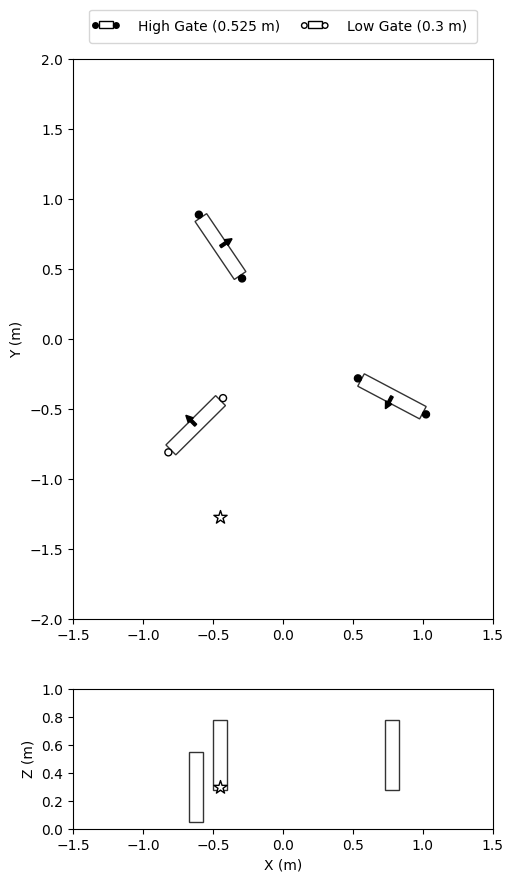

In [3]:
course = np.load(os.path.join(COURSE, "course.npy"))

_, axs = course_base_plot()
add_gates_to_course(course, axs, has_end=False)

In [ ]:
B = 250
w = 0.0
sampler = (SamplerType.GAMMA_CTM, 2)
cudnn_benchmark(B, model, vae_downsample, "cuda", sampler, w=w)

[ 2838886041.py:40 ] Considered trajectories from 0


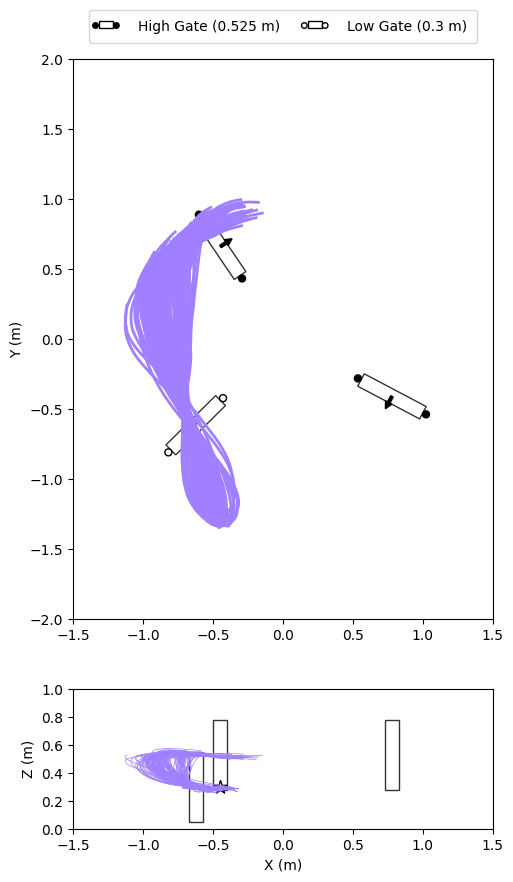

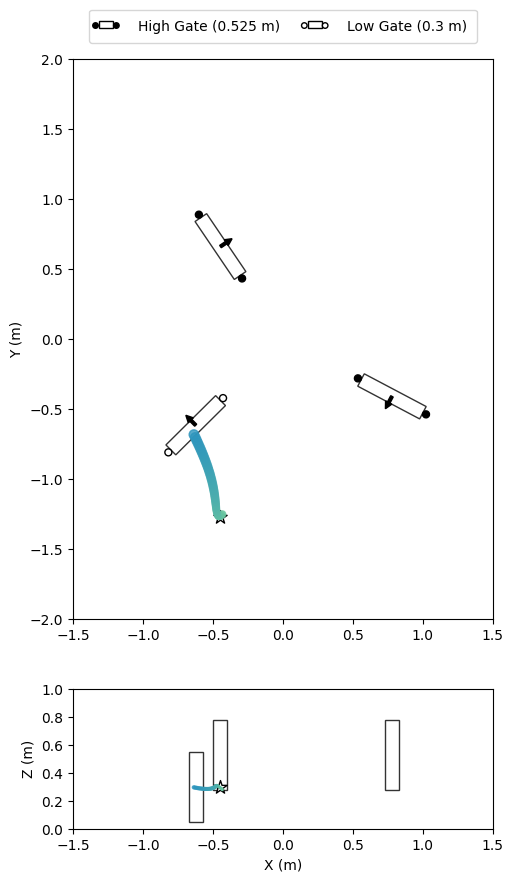

[ 2838886041.py:40 ] Considered trajectories from 1


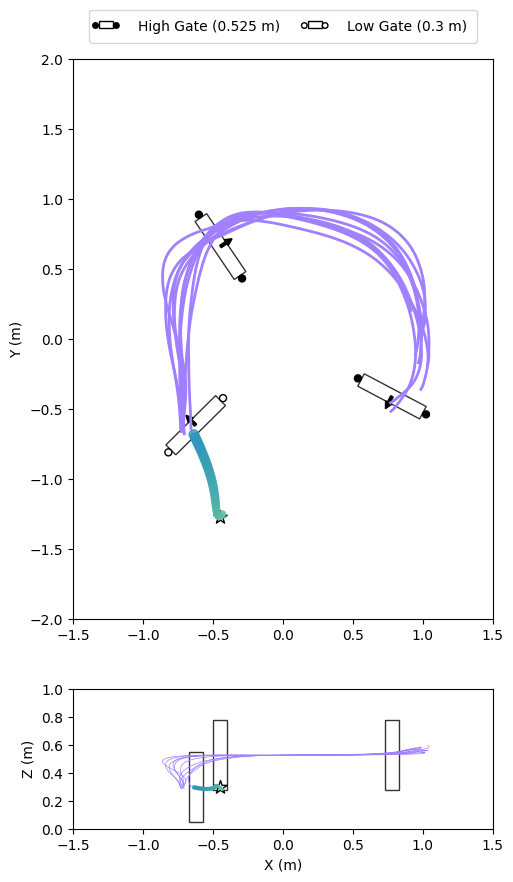

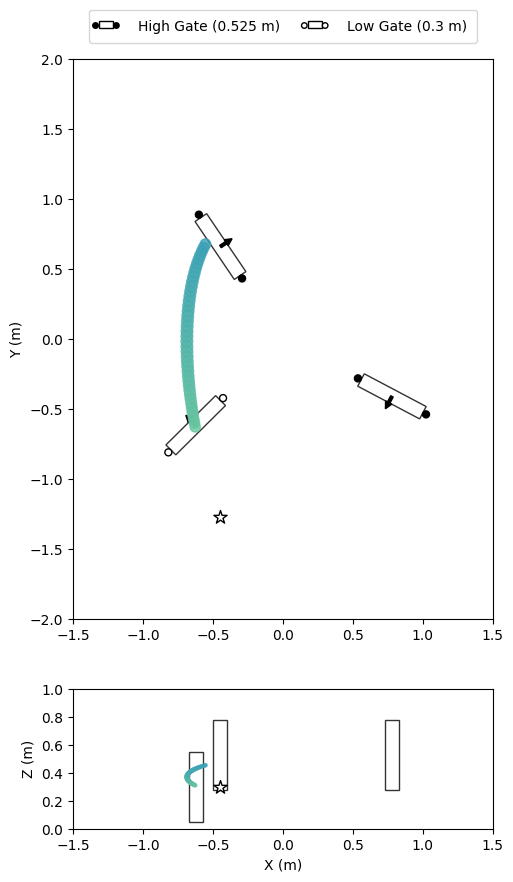

[ 2838886041.py:40 ] Considered trajectories from 2


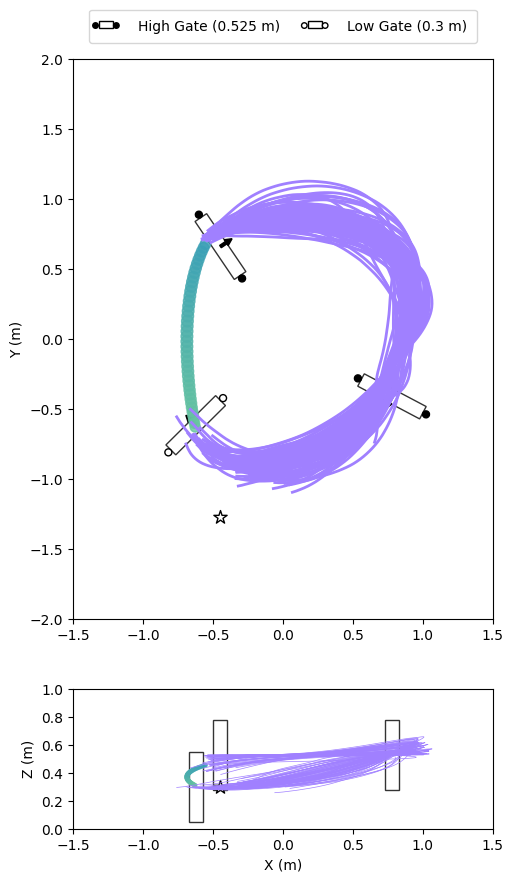

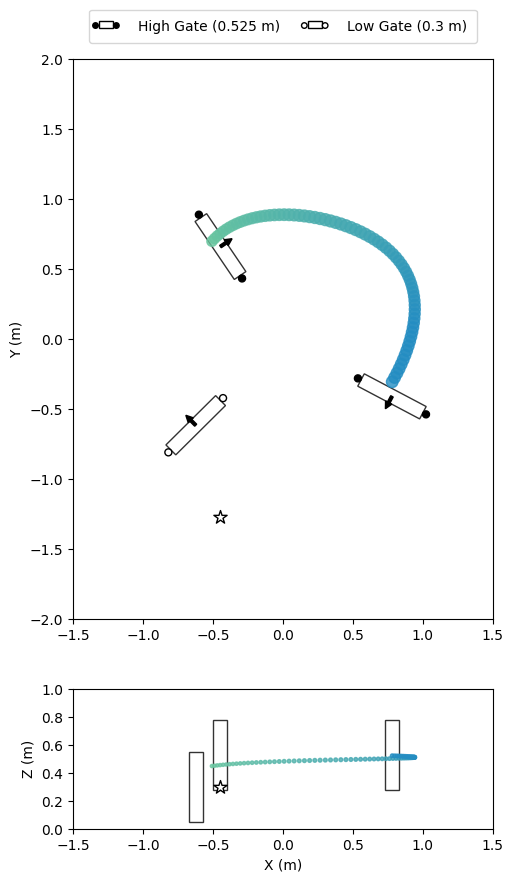

[ 2838886041.py:40 ] Considered trajectories from 3


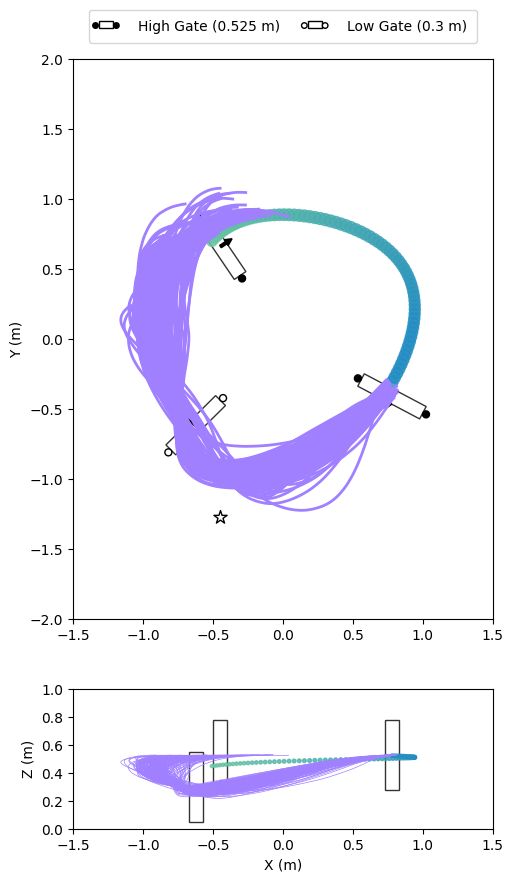

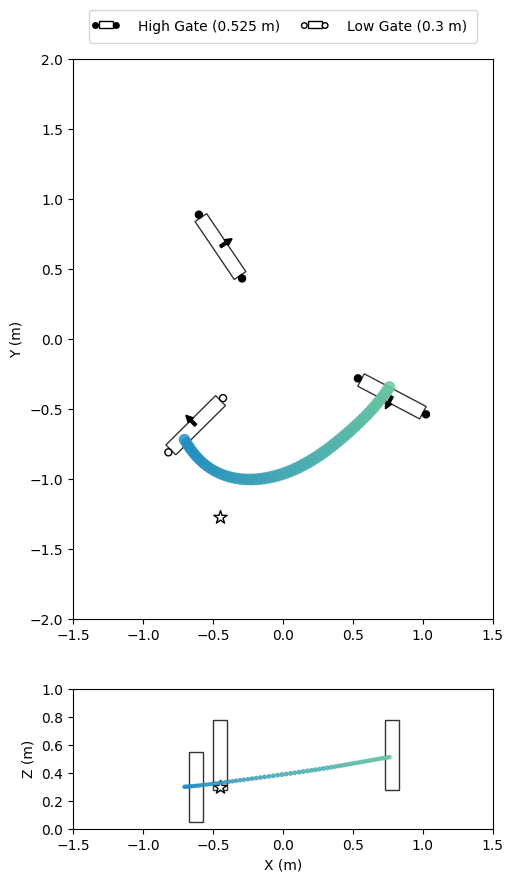

[ 2838886041.py:40 ] Considered trajectories from 1


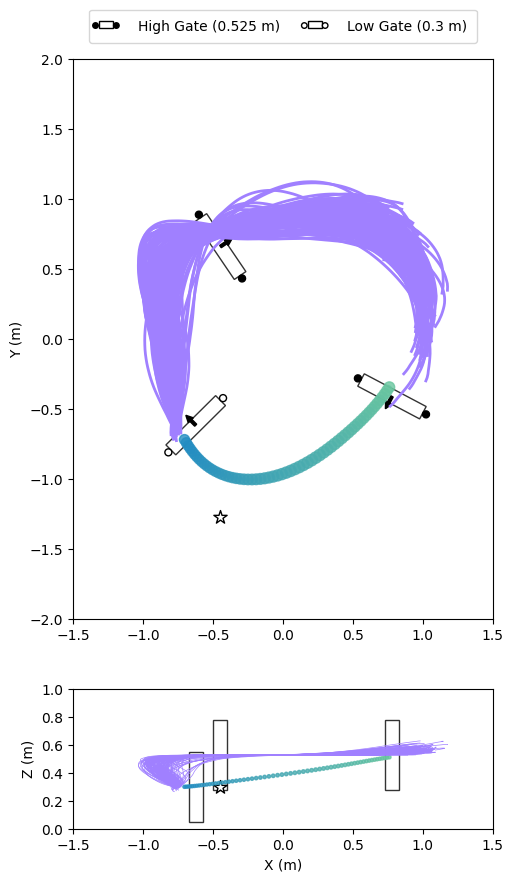

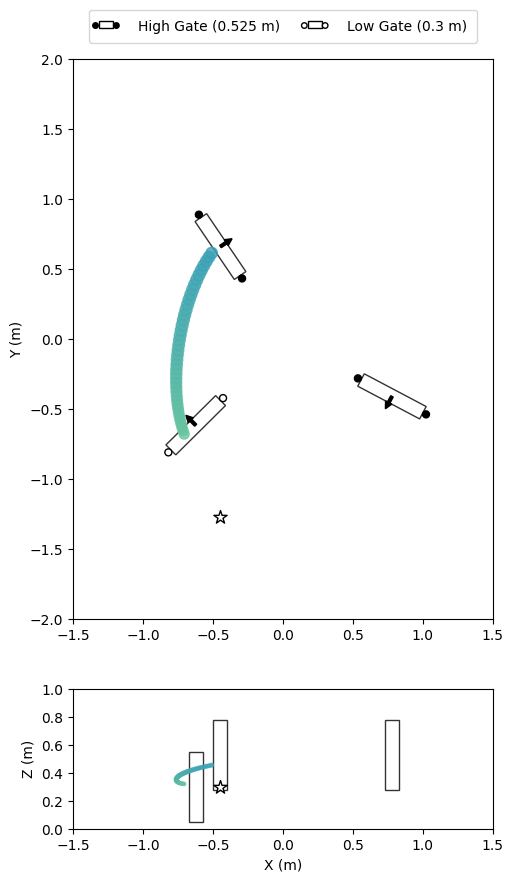

[ 2838886041.py:40 ] Considered trajectories from 2


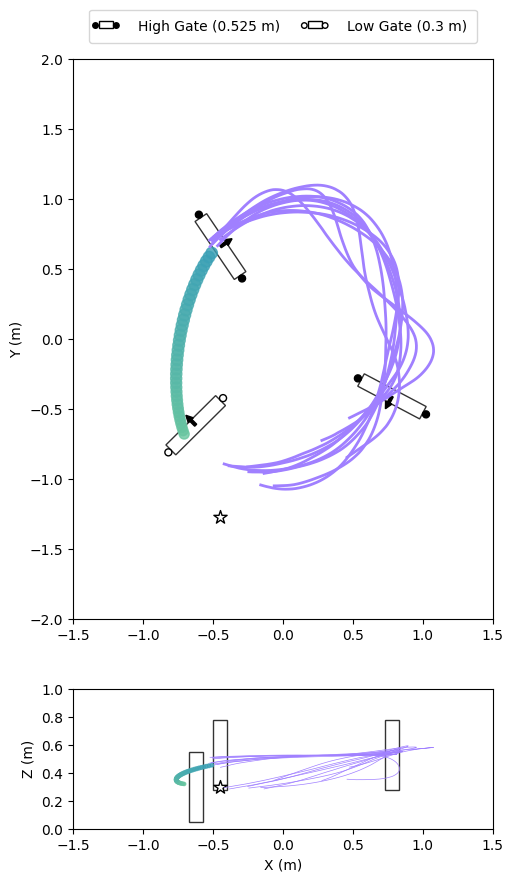

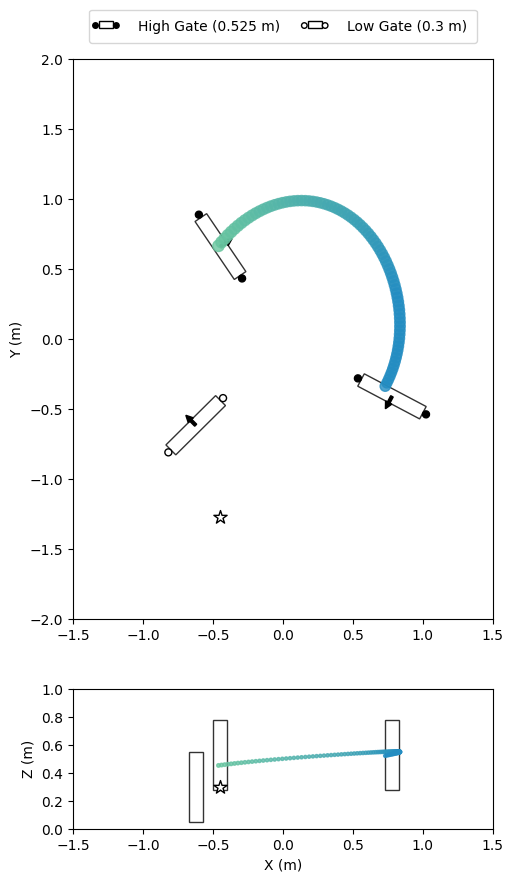

[ 2838886041.py:40 ] Considered trajectories from 3


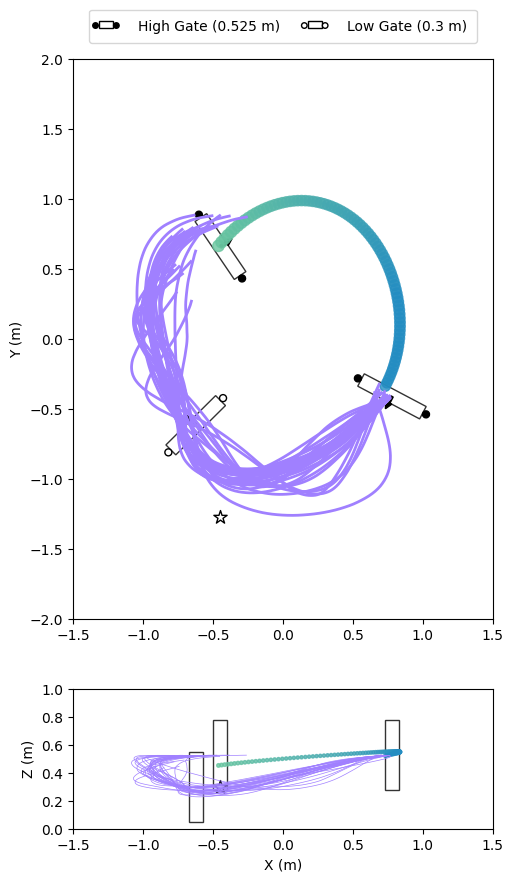

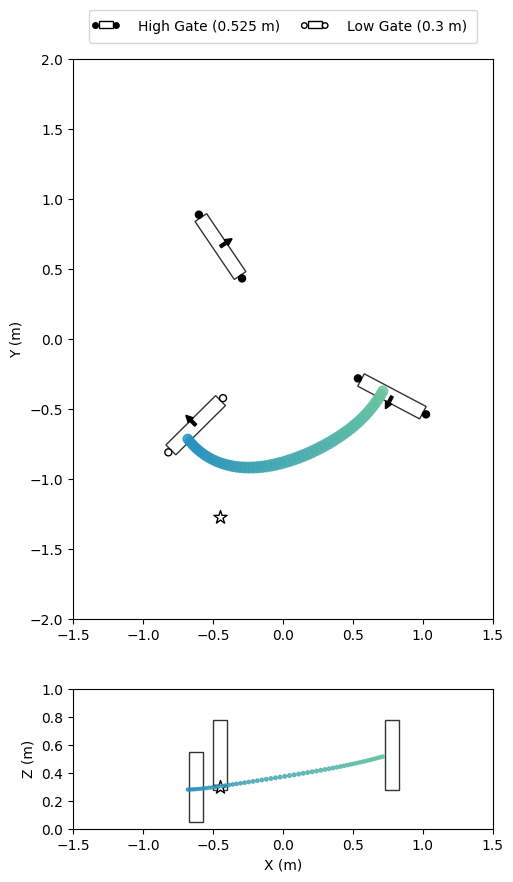

In [12]:
current_traj = None

gate_idx = 0

computation_times = []
trajectory_times = []
trajectories = []

LAPS = 2
gates_per_lap = course.shape[0] - 1
iterations = gates_per_lap * LAPS + 1
for i in range(iterations):
    # Provide the full course because the 0th position will be used for creating the local conditioning
    global_context = course
    if current_traj is not None:
        global_context = np.vstack((course[gate_idx + 1:], course[1:gate_idx]))    
    
    s = time.time()
    next_traj, candidates = plan(
        B,
        global_context,
        sampler,
        w,
        ScoringMethod.FAST,
        model,
        vae_downsample,
        "cuda",
        current_traj=current_traj,
        ignore_filter_step=False
    )
    trajectories.append(next_traj)
    
    computation_times.append(
        time.time() - s
    )
    trajectory_times.append(
        next_traj[0].shape[0] / 30
    )
    
    print(f"Considered trajectories from {gate_idx}")
    _, axs = course_base_plot()
    add_gates_to_course(course, axs, has_end=False)
    if current_traj:
        add_trajectory_to_course(axs, current_traj[0])
    for traj in candidates:
        add_trajectory_to_course(axs, traj.cpu().numpy(), reference=True)
    plt.show()
    plt.close()
    
    _, axs = course_base_plot()
    add_gates_to_course(course, axs, has_end=False)
    add_trajectory_to_course(axs, next_traj[0])
    plt.show()
    plt.close()
    
    gate_idx += 1
    current_traj = next_traj
    
    # Looped back around to previous gate
    if gate_idx == len(course):
        gate_idx = 1
    

In [7]:
print(sum(trajectory_times))

[ 2770381850 ] 12.966666666666667


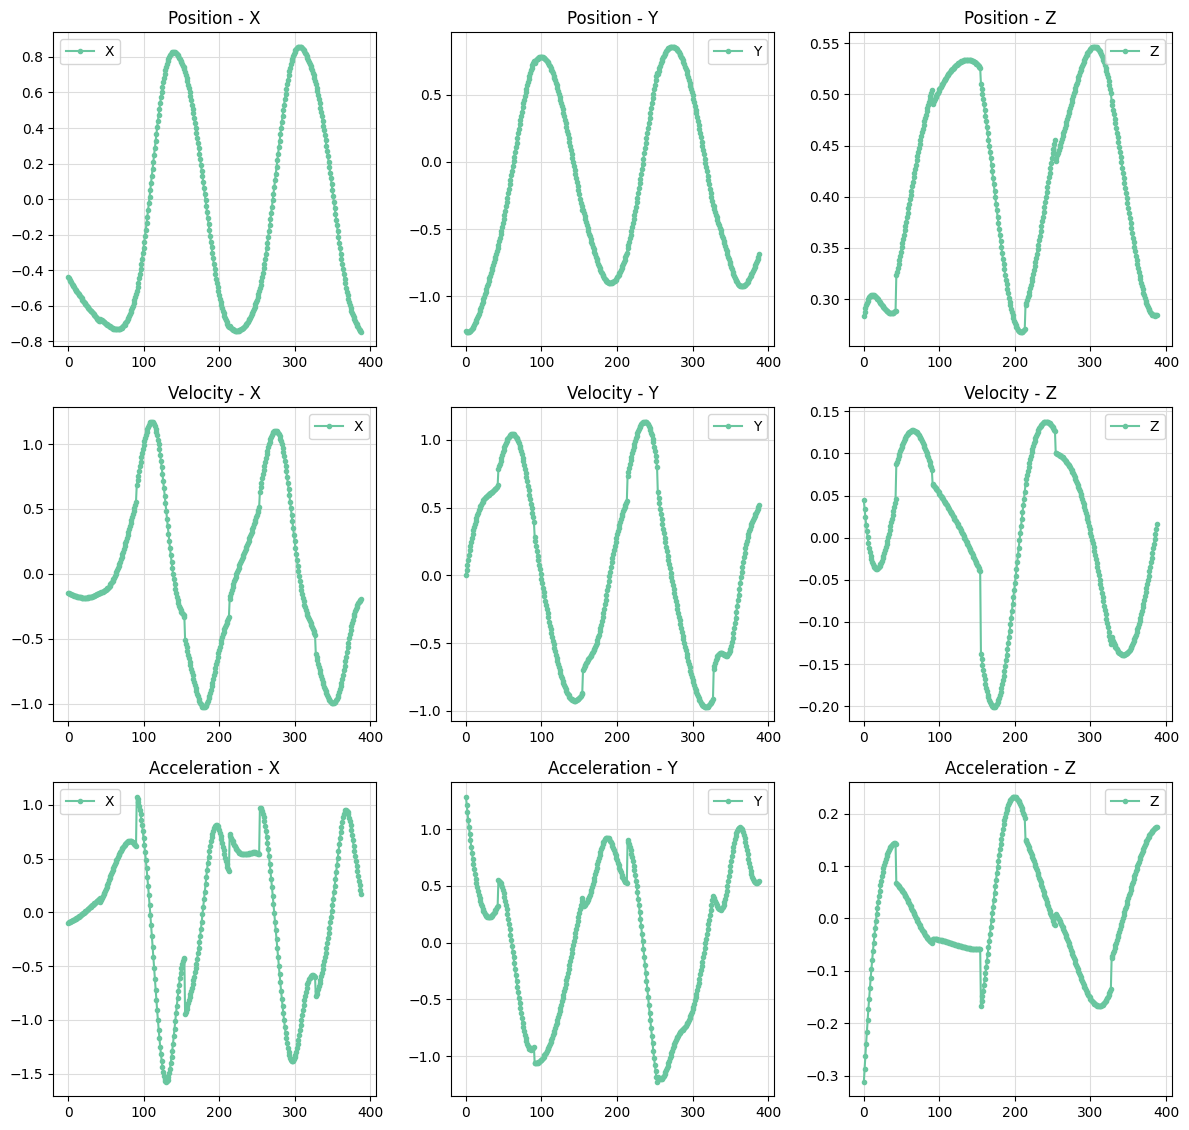

In [8]:
states = [np.vstack([t[idx] for t in trajectories]) for idx in range(3)]
plot_states(*states)

In [12]:
print(computation_times[1:])
print(trajectory_times)

[ 87713355 ] [0.05260419845581055, 0.05065655708312988, 0.05229926109313965, 0.05001974105834961, 0.05059814453125, 0.04999947547912598]
[ 87713355 ] [2.3, 1.5333333333333334, 2.966666666666667, 2.433333333333333, 1.6, 3.0, 2.4]


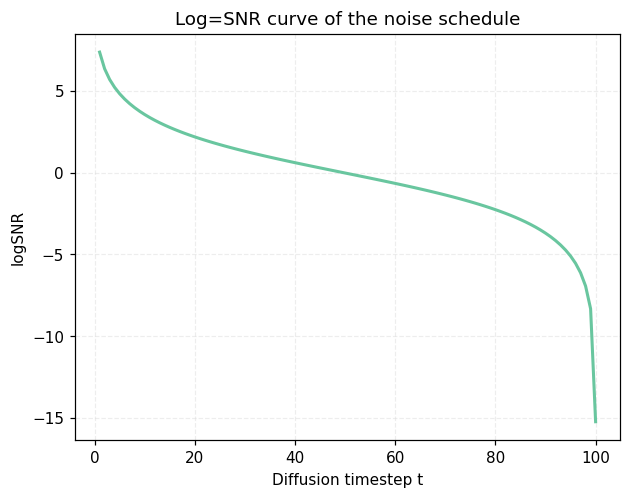

In [10]:
alpha_bar = model.alpha_bar.cpu()

snr = alpha_bar / (1.0 - alpha_bar)
log_snr = torch.log(snr)

steps = torch.arange(1, len(alpha_bar) + 1)

plt.figure(dpi=110)
plt.plot(steps, log_snr.numpy(), linewidth=2)
plt.xlabel("Diffusion timestep t")
plt.ylabel("logSNR")
plt.title("Log=SNR curve of the noise schedule")
plt.grid(True, linestyle="--", alpha=0.5)

# Optional: put t = 0 (highest signal) on the right by reversing the x‑axis
# plt.gca().invert_xaxis()

plt.show()

In [ ]:
mus, _ = model.encoder(candidates)

torch.Size([42, 16, 4])

KeyboardInterrupt: 

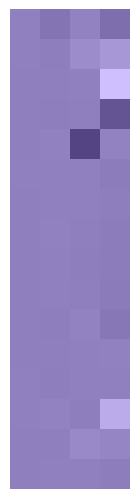

In [15]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap, Normalize, to_rgb


for mu_idx, mu in enumerate(mus):
    colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color'][:3]
    base_color = colors[2]

    # Convert to RGB and create light/dark variants
    rgb = np.array(to_rgb(base_color))
    light_rgb = 1 - 0.5 * (1 - rgb)  # Move halfway to white
    dark_rgb = 0.5 * rgb             # Move halfway to black

    # Create the custom colormap
    cmap = LinearSegmentedColormap.from_list("custom_shade", [light_rgb, dark_rgb])

    # Normalize as before
    norm = Normalize(vmin=-1.5, vmax=1.5)

    # Plot
    plt.imshow(mu.cpu().squeeze(0).numpy(), cmap=cmap, norm=norm)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.savefig(f"{mu_idx}.pdf")

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
import numpy as np
import matplotlib

idx =0
for trajectory in candidates[:4]:
    trajectory = trajectory.cpu().numpy()
    
    # Custom colormap from default matplotlib colors
    colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color'][:3]
    primary_colors = [colors[0], colors[1]]
    colormap = LinearSegmentedColormap.from_list('custom_map', primary_colors)
    norm = Normalize(vmin=0, vmax=1)  # since we're using step/128

    # Create the plot
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    fig.patch.set_alpha(0)  # Transparent background
    ax.axis('off')

    # Compute color values based on step progress
    steps = np.linspace(0, 1, len(trajectory))
    colors = colormap(norm(steps))

    # Plot segment by segment
    for i in range(len(trajectory) - 1):
        xs, ys, zs = trajectory[i:i+2, 0], trajectory[i:i+2, 1], trajectory[i:i+2, 2]
        ax.plot(xs, ys, zs, color=colors[i], linewidth=8)

    # Remove padding
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax.set_position([0, 0, 1, 1])

    # Save as clean SVG
    plt.savefig(f'trajectory{idx}.svg', transparent=True, format='svg', bbox_inches='tight', pad_inches=0)
    plt.close()
    idx += 1


[ 394360312 ] trajectory126.svg
[ 394360312 ] trajectory126.svg
[ 394360312 ] trajectory126.svg
[ 394360312 ] trajectory126.svg
